<a href="https://colab.research.google.com/github/klandermans/hello3dworld/blob/main/3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello 3D World 🌍🎥

This project is a **work-in-progress** demonstration of how to go from **multi-camera images** to a basic **3D reconstruction** using Python.

Currently, there is **no real image data** yet — just a few example coordinates in 3D space. The goal is to build toward a working pipeline where pixel detections from multiple camera angles are triangulated into 3D positions.

In [27]:
import numpy as np

# Camera coordinates in world space
CAM_COORDS = {
    "217": [9238.377, 9900.058, 4804.996],
    "218": [396.4734, 10038.96, 4843.1],
    "219": [5148.143, 14969.01, 5629.784],
    "221": [470.8995, 10538.52, 4838.071],
    "222": [4629.804, 3303.612, 5622.846],
    "223": [4612.065, 14951.8, 5637.818],
    "224": [9167.643, 10376.84, 4835.977],
    "225": [5143.774, 3319.927, 5630.942],
}

def getFromMagicTable(x,y,camera):
    """

    Stuurt de 3D-coördinaten van een pixel in de wereldcoördinaten terug.
    Dit is een snapshot van de tabellen om de demo snel te maken.

    row[0] = x 150cm
    row[1] = y 150cm
    row[2] = x 0cm
    row[3] = y 0cm
    """
    magic_table = {
    '222-1140-231' :[5607.293920138013,6914.644262489183,5818.741629167525,5818.741629167525],
    '225-1067-211' :[5705.8210958570535,6909.734201632857,5827.18894524609,5827.18894524609],
    '222-1138-229' :[5596.06561207702,6928.562454311799,5805.084447490738,5805.084447490738],
    '225-1065-211' :[5694.2472503192175,6909.449551140021,5813.1158575846475,5813.1158575846475],
    '222-1172-229' :[5803.707520296461,6952.683263046729,6057.642824840503,6057.642824840503],
    '225-1075-211' :[5752.186661877232,6910.946900201755,5883.566635179942,5883.566635179942],
    '222-1320-632' :[6471.71531815239,4542.6365296661415,6870.152047714652,6870.152047714652],
    '225-1189-617' :[6187.1737225486995,4530.646202816558,6412.484272486485,6412.484272486485],



    }
    row =  magic_table[f'{camera}-{x}-{y}']
    return row[0], row[1], row[2], row[3]

def triangulate_xyz_from_cameras(kp1, cam1_xyz, kp2, cam2_xyz):
    """
    Berekent het 3D-punt dat het dichtst bij de twee waargenomen lijnen ligt vanuit twee camera's,
    waarbij de inputpunten (kp1, kp2) al op het wereldvlak Z=0 liggen.
    :param kp1: (x, y) wereldcoördinaten op Z=0 vanaf camera 1
    :param cam1_xyz: (x, y, z) positie van camera 1 in wereldcoördinaten
    :param kp2: (x, y) wereldcoördinaten op Z=0 vanaf camera 2
    :param cam2_xyz: (x, y, z) positie van camera 2 in wereldcoördinaten
    :return: (x, y, z) coördinaat in 3D-ruimte
    """
    p1 = np.array(cam1_xyz)
    d1 = np.array([kp1[0] - cam1_xyz[0], kp1[1] - cam1_xyz[1], 0.0 - cam1_xyz[2]])
    d1 = d1 / np.linalg.norm(d1)

    p2 = np.array(cam2_xyz)
    d2 = np.array([kp2[0] - cam2_xyz[0], kp2[1] - cam2_xyz[1], 0.0 - cam2_xyz[2]])
    d2 = d2 / np.linalg.norm(d2)

    cross_d = np.cross(d1, d2)
    denom = np.linalg.norm(cross_d) ** 2
    if denom == 0:
        return None  # Lijnen zijn (bijna) parallel

    t = np.dot(np.cross((p2 - p1), d2), cross_d) / denom
    s = np.dot(np.cross((p2 - p1), d1), cross_d) / denom

    point1 = p1 + t * d1
    point2 = p2 + s * d2

    midpoint = (point1 + point2) / 2.0
    return midpoint[0], midpoint[1], midpoint[2]

import numpy as np

points = {}


In [41]:
# bovenop muur (verwacht een z van rond de 150cm)
x1, y1, x10, y10 = getFromMagicTable(1172, 1080-851, 222)
x3, y4, x30, y40 = getFromMagicTable(1075, 1080-869, 225)
d3 =  triangulate_xyz_from_cameras([x10,y10], CAM_COORDS['222'], [x30,y40],  CAM_COORDS['225'])
points['Muur boven'] = d3

print(d3)

(np.float64(5664.168207636152), np.float64(5221.7756858296), np.float64(1583.9440334866383))


In [42]:
# vloer bij muur muur
x1, y1, x10, y10 = getFromMagicTable(1138, 1080-851, 222)
x3, y2, x30, y40 = getFromMagicTable(1065, 1080-869, 225)
d3 =  triangulate_xyz_from_cameras([x10,y10], CAM_COORDS['222'], [x30,y40],  CAM_COORDS['225'])
points['Muur vloer'] = d3
print(d3)

(np.float64(5823.188950192189), np.float64(5847.065940979641), np.float64(-85.5395423184541))


In [43]:
# ## deel 4 paal in de lucht
x1, y1, x10, y10 = getFromMagicTable(1320, 632, 222)
x3, y2, x30, y40 =  getFromMagicTable(1189, 617, 225)
d3 =  triangulate_xyz_from_cameras([x10,y10], CAM_COORDS['222'], [x30,y40],  CAM_COORDS['225'])
points['Paal in lucht'] = d3
print(d3)


(np.float64(5710.059719908937), np.float64(4878.672816163011), np.float64(2976.1351963936154))


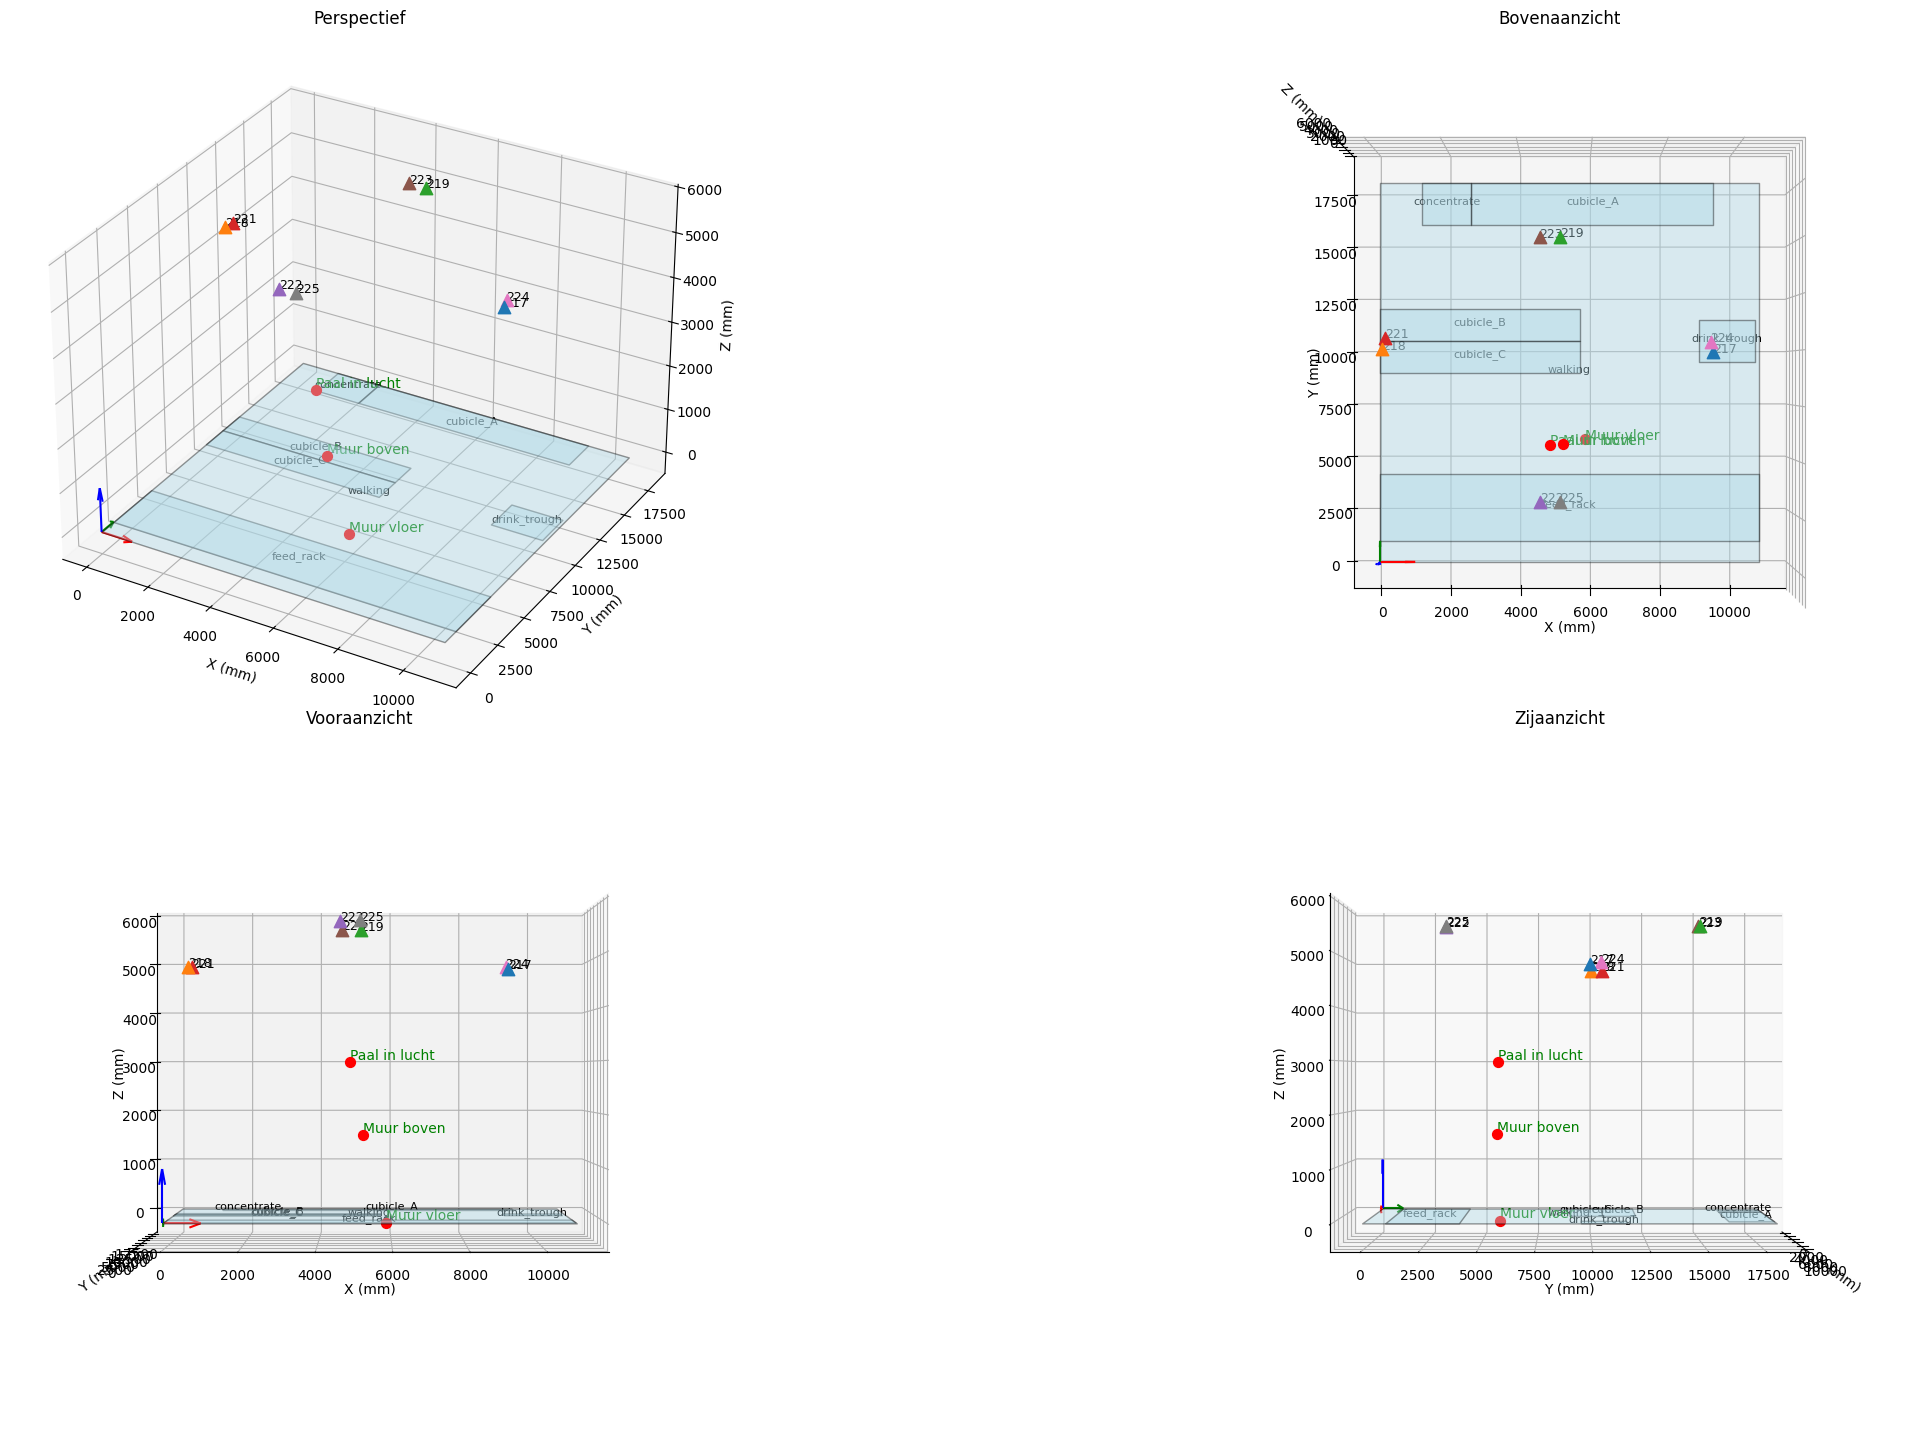

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


arrow_len = 1000
# Draai vloerdata 90 graden met de klok mee en schaal naar mm
data = {
    "area_name": [
        "walking",
        "cubicle_A",
        "cubicle_B",
        "cubicle_C",
        "feed_rack",
        "drink_trough",
        "concentrate"
    ],
    "x1": [0.0, 2.6, 0.0, 0.0, 0.0, 9.1, 1.2],
    "y1": [-18.0, -18.0, -12.0, -10.5, -4.2, -11.5, -18.0],
    "x2": [10.8, 9.5, 5.7, 5.7, 10.8, 10.7, 2.6],
    "y2": [-18.0, -18.0, -12.0, -10.5, -4.2, -11.5, -18.0],
    "x3": [0.0, 2.6, 0.0, 0.0, 0.0, 9.1, 1.2],
    "y3": [0.0, -16.0, -10.5, -9.0, -1.0, -9.5, -16.0],
    "x4": [10.8, 9.5, 5.7, 5.7, 10.8, 10.7, 2.6],
    "y4": [0.0, -16.0, -10.5, -9.0, -1.0, -9.5, -16.0]
}



# Rotatie van 180 graden en schaling naar mm
for i in range(1, 5):
    x_key, y_key = f"x{i}", f"y{i}"
    data[x_key] = [x * 1000 for x in data[x_key]]
    data[y_key] = [-y * 1000 for y in data[y_key]]

# fig = plt.figure(figsize=(20, 10))
fig = plt.figure(figsize=(24, 14))  # of nog groter bij veel details

views = [
    ("Perspectief", 30, -60),
    ("Bovenaanzicht", 90, -90),
    ("Vooraanzicht", 0, -90),   # kijkt langs X-as → toont Y vs Z
    ("Zijaanzicht", 0, 0),      # kijkt langs Y-as → toont X vs Z
]

for idx, (title, elev, azim) in enumerate(views):
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    ax.set_title(title)

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_zlabel("Z (mm)")
    ax.view_init(elev=elev, azim=azim)

    # Assen check
    ax.quiver(0, 0, 0, 1000, 0, 0, color='r', label='X-as')  # Rood
    ax.quiver(0, 0, 0, 0, 1000, 0, color='g', label='Y-as')  # Groen
    ax.quiver(0, 0, 0, 0, 0, 1000, color='b', label='Z-as')  # Blauw

    # Vloergebieden
    for i in range(len(data["area_name"])):
        x_poly = [data["x1"][i], data["x2"][i], data["x4"][i], data["x3"][i]]
        y_poly = [data["y1"][i], data["y2"][i], data["y4"][i], data["y3"][i]]
        z_poly = [0, 0, 0, 0]
        verts = [list(zip(x_poly, y_poly, z_poly))]
        area = Poly3DCollection(verts, alpha=0.4, facecolor='lightblue', edgecolor='k')
        ax.add_collection3d(area)
        cx, cy = np.mean(x_poly), np.mean(y_poly)
        ax.text(cx, cy, 0.1, data["area_name"][i], fontsize=8, ha='center')

    # Camera’s
    for cam_id, pos in CAM_COORDS.items():
        pos = np.array(pos)
        ax.scatter(*pos, marker='^', s=80, label=f"Cam {cam_id}")
        ax.text(*pos, f"{cam_id}", fontsize=9, color='black')
        # ax.quiver(*pos, 0, 0, -arrow_len, color='black', linewidth=1)


    for p in points:
        x,y,z = points[p]
        ax.scatter(y, x, z, c='red', s=50)
        ax.text(y, x, z + 50, f"{p} ", color='green')


plt.tight_layout()  # deze mag weg als je subplots_adjust gebruikt
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
plt.show()
